In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")  # Seaborn varsayılanlarını bozma
sns.set(rc={"figure.dpi": 110})


In [2]:
df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


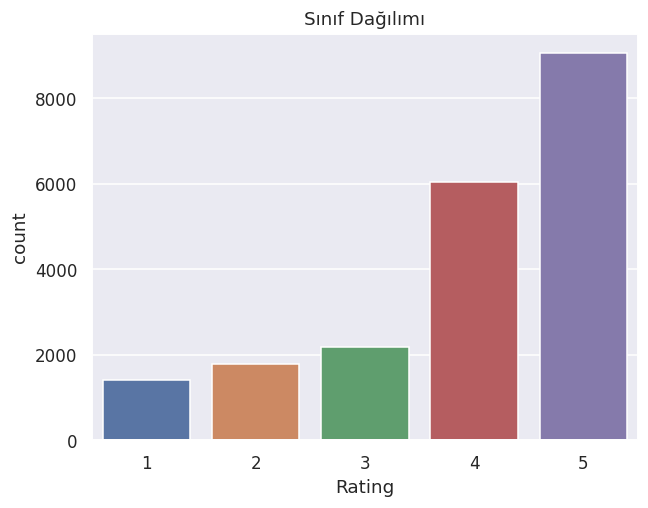

Rating
5    44.19
4    29.47
3    10.66
2     8.75
1     6.93
Name: proportion, dtype: float64


In [4]:
sns.countplot(x="Rating", data=df)
plt.xticks([0,1,2,3,4], ["1", "2","3","4","5"])
plt.title("Sınıf Dağılımı")
plt.show()

# Yüzde olarak da raporla
print(
    df["Rating"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
)


In [5]:
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [6]:

def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [7]:
df['Rating'] = df['Rating'].apply(rating)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Netral,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281


In [8]:
length = df['Length'].sum()
length

14853861

In [9]:
# ─────────────────────────────
#   Stemming & Lemmatization
# ─────────────────────────────
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# --- NLTK kaynak kontrolü ---
def ensure_nltk(pkg):
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg.split("/")[-1])

for pkg in ["tokenizers/punkt", "corpora/stopwords", "corpora/wordnet", "corpora/omw-1.4"]:
    ensure_nltk(pkg)

# --- Global objeler ---
stop_words  = set(stopwords.words("english"))
stemmer     = PorterStemmer()
lemmatizer  = WordNetLemmatizer()

def normalize(text: str, mode: str = "stem") -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    if mode == "lemma":
        processed = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    else:  # stem
        processed = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]

    return " ".join(processed)

print("‣ Stemming ve Lemmatization kolonları oluşturuluyor…")
df["clean_stem"]  = df["Review"].apply(lambda x: normalize(x, mode="stem"))
df["clean_lemma"] = df["Review"].apply(lambda x: normalize(x, mode="lemma"))
print("Tamamlandı.")
display(df[["clean_stem", "clean_lemma"]].head())


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


‣ Stemming ve Lemmatization kolonları oluşturuluyor…
Tamamlandı.


,clean_stem,clean_lemma
0,nice hotel expens park got good deal stay hote...,nice hotel expensive parking got good deal sta...
1,ok noth special charg diamond member hilton de...,ok nothing special charge diamond member hilto...
2,nice room experi hotel monaco seattl good hote...,nice room experience hotel monaco seattle good...
3,uniqu great stay wonder time hotel monaco loca...,unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...


In [10]:
df['Length_stem'] = df['clean_stem'].apply(len)
df['Length_lemma'] = df['clean_lemma'].apply(len)
new_length_stem = df['Length_stem'].sum()
new_length_lemma = df['Length_lemma'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after stem: {}'.format(new_length_stem))
print('Total text length after lemma: {}'.format(new_length_lemma))

Total text length before cleaning: 14853861
Total text length after stem: 12362285
Total text length after lemma: 13759366


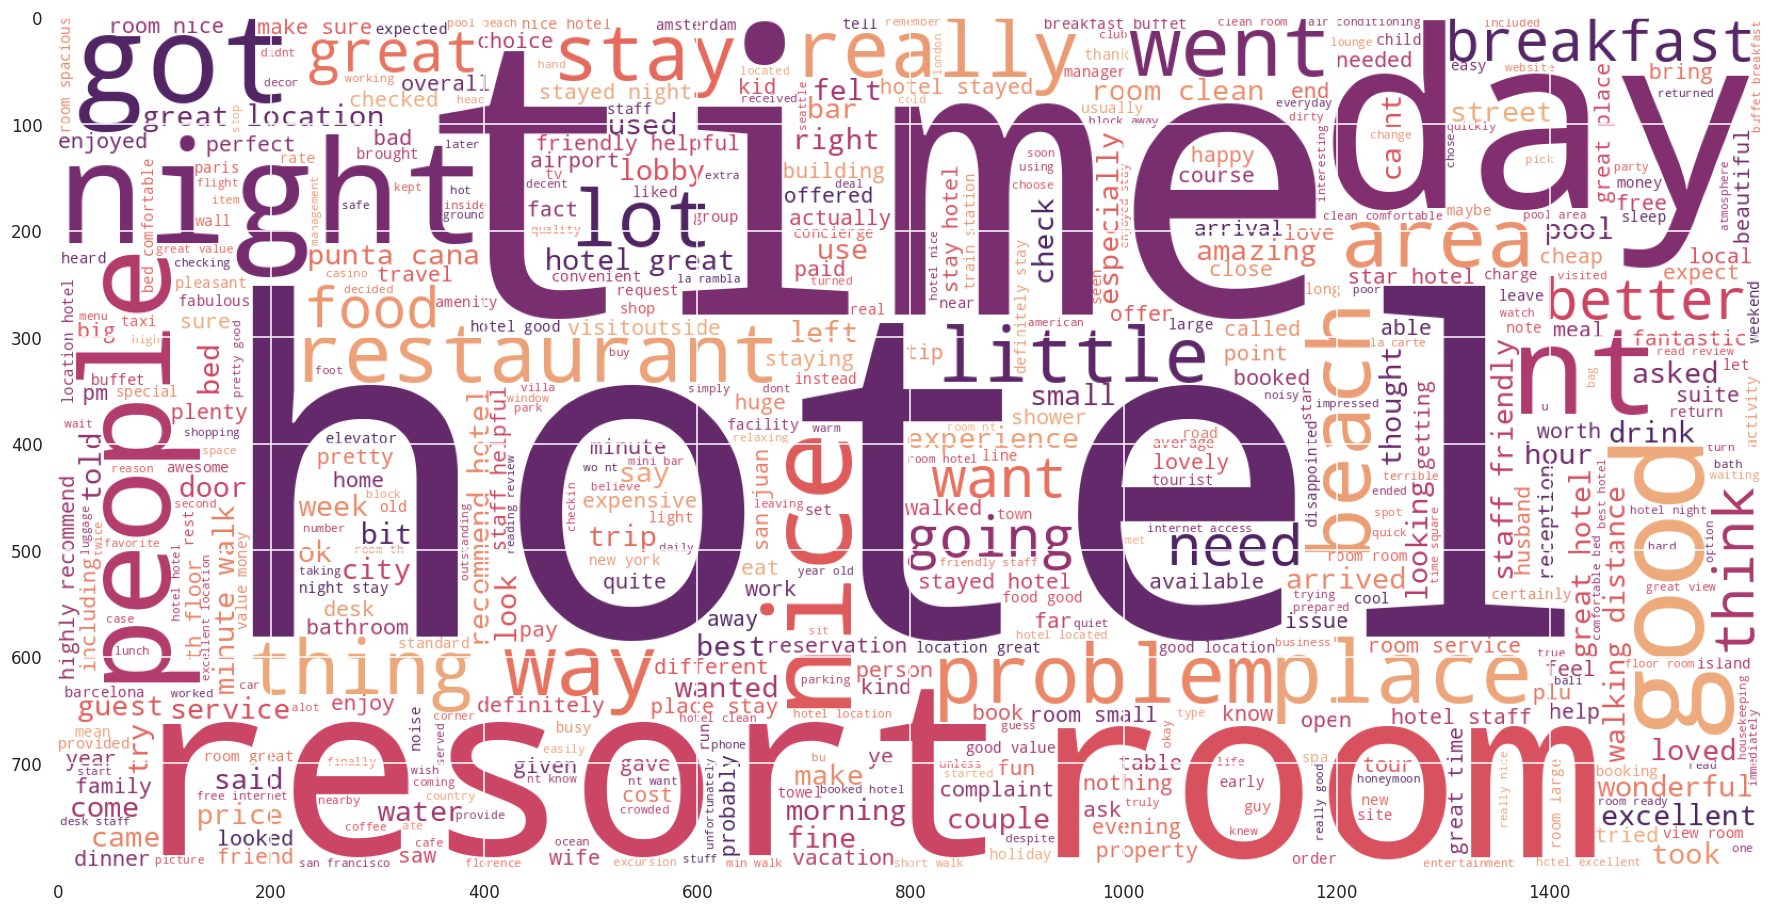

In [11]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['clean_lemma']))

plt.imshow(wc)

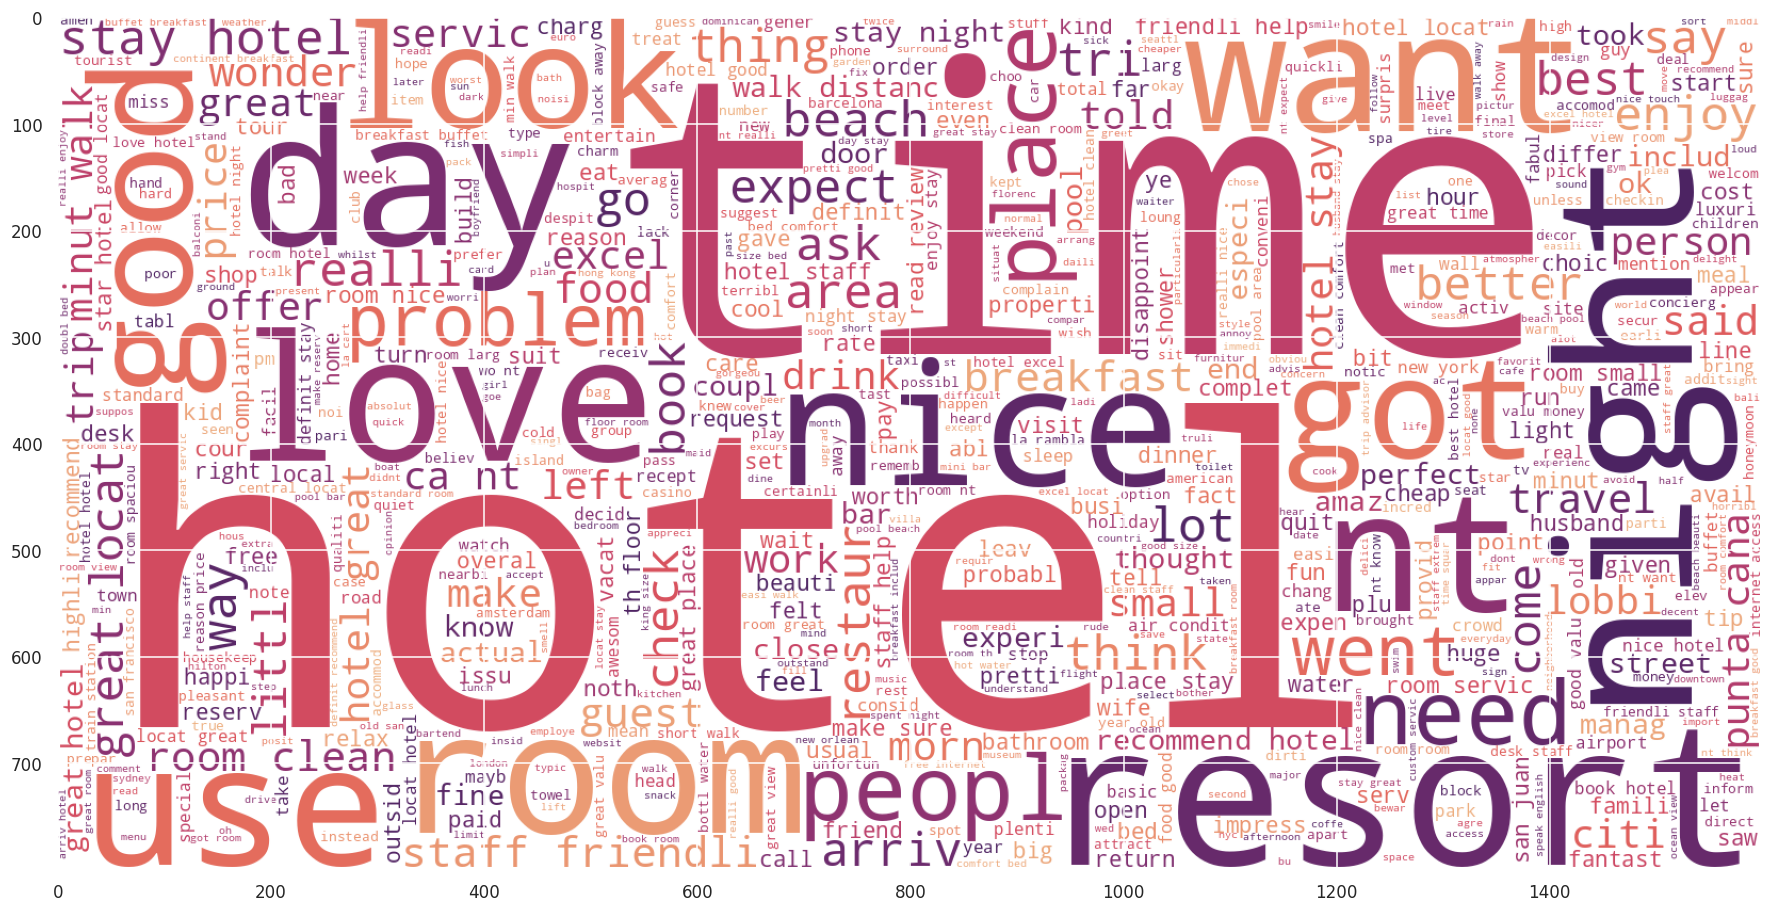

In [12]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['clean_stem']))

plt.imshow(wc)

In [13]:
# 4.1  Konfigürasyon
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC  

feature_setups = {
    "bow_stem_nb":   ("clean_stem",  CountVectorizer(max_features=6000), MultinomialNB()),  
    "tfidf_stem_lr": ("clean_stem",  TfidfVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "tfidf_lemma_lr": ("clean_lemma",  TfidfVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "bow_stem_cnb":  ("clean_stem",  CountVectorizer(max_features=6000), ComplementNB()),
    "tfidf_lemma_svc": ("clean_lemma", TfidfVectorizer(max_features=6000), LinearSVC()),
    "tfidf_stem_svc": ("clean_stem", TfidfVectorizer(max_features=6000), LinearSVC()),
    "tfidf_stem_sgd":("clean_stem",  TfidfVectorizer(max_features=6000), SGDClassifier(loss="hinge", max_iter=1000)),
    "bow_stem_lr":  ("clean_stem",  CountVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "bow_lemma_lr":  ("clean_lemma",  CountVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "bow_stem_svc": ("clean_stem",  CountVectorizer(max_features=6000), LinearSVC()),
    "bow_lemma_svc": ("clean_lemma",  CountVectorizer(max_features=6000), LinearSVC()),
    "bow_stem_sgd": ("clean_stem",  CountVectorizer(max_features=6000), SGDClassifier(loss="hinge", max_iter=1000)),
    "tfidf_stem_nb":  ("clean_stem",  TfidfVectorizer(max_features=6000), MultinomialNB()),
    "tfidf_lemma_nb":  ("clean_lemma",  TfidfVectorizer(max_features=6000), MultinomialNB()),
    "tfidf_stem_cnb": ("clean_stem",  TfidfVectorizer(max_features=6000), ComplementNB()),
}
print(f"{len(feature_setups)} kombinasyon tanımlandı.")


15 kombinasyon tanımlandı.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time, pandas as pd
from sklearn.metrics import classification_report


results = []

for name, (text_col, vect, model) in feature_setups.items():
    print(f"\n⏳ {name} – vektörizasyon ve eğitim başlıyor")

    # --------- Train–Test bölmesi ---------
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col],
        df["Rating"],
        test_size=0.2,
        random_state=42,
        stratify=df["Rating"]
    )

    # --------- Vektörizasyon süresi ölç ---------
    t_vec = time.time()
    X_train_vec = vect.fit_transform(X_train)
    X_test_vec  = vect.transform(X_test)
    vec_time = time.time() - t_vec

    # --------- Model fit süresi ölç ---------
    t_fit = time.time()
    model.fit(X_train_vec, y_train)
    fit_time = time.time() - t_fit

    y_pred = model.predict(X_test_vec)

    avg = "macro"          # veya "weighted" / "micro"

    results.append({
        "setup":       name,
        "vectorizer":  type(vect).__name__,
        "model":       type(model).__name__,
        "accuracy":    round(accuracy_score(y_test, y_pred), 4),
        "f1":          round(f1_score(y_test, y_pred, average=avg), 4),
        "precision":   round(precision_score(y_test, y_pred, average=avg), 4),
        "recall":      round(recall_score(y_test, y_pred, average=avg), 4),
        "vec_s":       round(vec_time, 1),
        "fit_s":       round(fit_time, 1),
    })

print(classification_report(y_test, y_pred, digits=3))   # her sınıf için P/R/F1
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
display(results_df)



⏳ bow_stem_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_lr – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_cnb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_svc – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_svc – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_sgd – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_lemma_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_svc – vektörizasyon ve eğitim başlıyor


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⏳ bow_lemma_svc – vektörizasyon ve eğitim başlıyor


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⏳ bow_stem_sgd – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_nb – vektörizasyon ve eğitim başlıyor


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



⏳ tfidf_lemma_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_cnb – vektörizasyon ve eğitim başlıyor
              precision    recall  f1-score   support

         Bad      0.585     0.928     0.718       643
        Good      0.913     0.914     0.914      3019
      Netral      0.491     0.062     0.110       437

    accuracy                          0.826      4099
   macro avg      0.663     0.635     0.580      4099
weighted avg      0.817     0.826     0.797      4099



,setup,vectorizer,model,accuracy,f1,precision,recall,vec_s,fit_s
5,tfidf_stem_svc,TfidfVectorizer,LinearSVC,0.8575,0.6758,0.7141,0.6621,1.7,0.7
7,bow_stem_lr,CountVectorizer,LogisticRegression,0.8400,0.6721,0.6850,0.6621,1.7,13.3
0,bow_stem_nb,CountVectorizer,MultinomialNB,0.8214,0.6717,0.6677,0.6768,1.7,0.1
1,tfidf_stem_lr,TfidfVectorizer,LogisticRegression,0.8636,0.6700,0.7440,0.6514,1.8,3.2
2,tfidf_lemma_lr,TfidfVectorizer,LogisticRegression,0.8634,0.6688,0.7441,0.6498,1.8,4.9
4,tfidf_lemma_svc,TfidfVectorizer,LinearSVC,0.8544,0.6648,0.7005,0.6528,1.8,0.6
8,bow_lemma_lr,CountVectorizer,LogisticRegression,0.8326,0.6589,0.6713,0.6491,1.7,14.1
11,bow_stem_sgd,CountVectorizer,SGDClassifier,0.8434,0.6509,0.6813,0.6398,1.7,1.1
9,bow_stem_svc,CountVectorizer,LinearSVC,0.8212,0.6488,0.6555,0.6430,1.7,6.2
10,bow_lemma_svc,CountVectorizer,LinearSVC,0.8146,0.6415,0.6466,0.6367,1.8,5.7


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time, pandas as pd

# ---------- SADECE Good–Bad verisi ----------
df_bin = df[df["Rating"].isin(["Good", "Bad"])].copy()
df_bin["label_bin"] = df_bin["Rating"].map({"Bad": 0, "Good": 1})

print(df_bin["Rating"].value_counts())
print("Yeni veri boyutu:", len(df_bin))

results = []
avg = "binary"          # Good = pozitif (1), Bad = negatif (0)
# avg = "macro"         # istersen makro ortalama

for name, (text_col, vect, model) in feature_setups.items():
    print(f"\n⏳ {name} – vektörizasyon ve eğitim başlıyor")

    # --------- Train–Test bölmesi ---------
    X_train, X_test, y_train, y_test = train_test_split(
        df_bin[text_col],
        df_bin["label_bin"],
        test_size=0.2,
        random_state=42,
        stratify=df_bin["label_bin"]
    )

    # --------- Vektörizasyon ---------
    t_vec = time.time()
    X_train_vec = vect.fit_transform(X_train)
    X_test_vec  = vect.transform(X_test)
    vec_time = time.time() - t_vec

    # --------- Model fit ---------
    t_fit = time.time()
    model.fit(X_train_vec, y_train)
    fit_time = time.time() - t_fit

    y_pred = model.predict(X_test_vec)

    results.append({
        "setup":      name,
        "vectorizer": type(vect).__name__,
        "model":      type(model).__name__,
        "accuracy":   round(accuracy_score(y_test, y_pred), 4),
        "f1":         round(f1_score(y_test, y_pred, average=avg), 4),
        "precision":  round(precision_score(y_test, y_pred, average=avg), 4),
        "recall":     round(recall_score(y_test, y_pred, average=avg), 4),
        "vec_s":      round(vec_time, 1),
        "fit_s":      round(fit_time, 1),
    })

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
display(results_df)


Rating
Good    15093
Bad      3214
Name: count, dtype: int64
Yeni veri boyutu: 18307

⏳ bow_stem_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_lr – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_cnb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_svc – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_svc – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_sgd – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_lemma_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_svc – vektörizasyon ve eğitim başlıyor

⏳ bow_lemma_svc – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_sgd – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_cnb – vektörizasyon ve eğitim başlıyor


,setup,vectorizer,model,accuracy,f1,precision,recall,vec_s,fit_s
4,tfidf_lemma_svc,TfidfVectorizer,LinearSVC,0.9588,0.9752,0.9662,0.9844,1.6,0.1
6,tfidf_stem_sgd,TfidfVectorizer,SGDClassifier,0.9558,0.9735,0.9630,0.9841,1.5,0.1
1,tfidf_stem_lr,TfidfVectorizer,LogisticRegression,0.9549,0.9732,0.9539,0.9934,1.5,0.6
5,tfidf_stem_svc,TfidfVectorizer,LinearSVC,0.9552,0.9730,0.9664,0.9798,1.5,0.1
2,tfidf_lemma_lr,TfidfVectorizer,LogisticRegression,0.9536,0.9724,0.9527,0.9930,1.7,0.6
8,bow_lemma_lr,CountVectorizer,LogisticRegression,0.9528,0.9715,0.9659,0.9771,1.6,1.5
7,bow_stem_lr,CountVectorizer,LogisticRegression,0.9522,0.9712,0.9653,0.9771,1.5,2.1
11,bow_stem_sgd,CountVectorizer,SGDClassifier,0.9435,0.9660,0.9583,0.9738,1.5,0.2
0,bow_stem_nb,CountVectorizer,MultinomialNB,0.9421,0.9646,0.9718,0.9576,1.5,0.0
9,bow_stem_svc,CountVectorizer,LinearSVC,0.9399,0.9636,0.9620,0.9652,1.5,0.6


### Precision & Recall - Hızlı Tanım

| Ölçüt | Formül | Ne Yorumlar? | Ne Zaman Kritik? |
|-------|--------|--------------|------------------|
| **Precision** |  \(\displaystyle \frac{TP}{TP+FP}\)  | “_Model **pozitif** dediği örneklerin kaçı gerçekten pozitif?_”  | Yanlış-pozitiflerin maliyeti yüksekse (örn. spam ≠ ham, tıbbî tanı) |
| **Recall**    |  \(\displaystyle \frac{TP}{TP+FN}\)  | “_Gerçek pozitiflerin kaçı model tarafından **yakalandı**?_” | Kaçırılan pozitiflerin maliyeti yüksekse (örn. sahtekârlık, hastalık tespiti) |

> **TP** = True Positive  **FP** = False Positive  **FN** = False Negative

#### Örnek – AG News (4 sınıf)
| Sınıf | Precision | Recall | Yorumu |
|-------|-----------|--------|--------|
| **Good / Class-2** | 0.906 | 0.984 | Neredeyse tüm “Class-2” haberlerini yakalıyor (recall↑); yanlış-pozitif oranı da düşük (precision↑). |
| **Class-3** | 0.866 | 0.832 | 1 örnekten ≈ 17 %’i yanlış-pozitif, ≈ 17 %’i kaçıyor. İyileştirme alanı recall yönünde. |

#### Makro Ortalama vs. Weighted Ortalama
- **Macro**: Her sınıfın P/R ortalaması (sınıf dengesi gözetmez).  
- **Weighted**: Sınıf büyüklüğüyle ağırlıklar; dengesiz kümede domİnant sınıfın etkisi büyür.

